# Setup


In [ ]:
!pip install 'aif360[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from collections import OrderedDict

import sys

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset, BinaryLabelDataset

# Fairness preprocessing
from aif360.algorithms.preprocessing import Reweighing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import numpy as np



/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [ ]:
class DatasetGeneratorAlzheimer:
    def __init__(self, file_path):
        self.file_path= file_path
        self.df = pd.read_csv(self.file_path)


    # Bias calculation for the stacked model
    # We here define as bias the difference between the value of the metric (here accuracy) for a particular gender split and the mean
    # of the means of all the other splits.
    def calculate_bias(self,metrics, metric_name, ratios):
        bias = {}
        for i, ratio in enumerate(ratios):
            current_metric = metrics[ratio][metric_name]
            other_metrics = [metrics[r] for r in ratios if r != ratio]
            mean_other_metrics = np.mean([value[metric_name] for value in other_metrics])
            bias[ratio] = current_metric - mean_other_metrics
        return bias


    # Metrics function. Code provided in the tutorial 7 : Fairness II.
    def compute_metrics(self, dataset_true, dataset_pred,
                        unprivileged_groups, privileged_groups,
                        disp=True):
        """ Compute the key metrics """
        classified_metric_pred = ClassificationMetric(dataset_true,
                                                    dataset_pred,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)
        metrics = OrderedDict()
        metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                            classified_metric_pred.true_negative_rate())
        metrics["Accuracy between unprivileged and privileged groups"] = classified_metric_pred.accuracy()
        metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
        metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
        metrics["Average Odds Difference between unprivileged and privileged group"] = classified_metric_pred.average_odds_difference()
        metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
        metrics["Theil index"] = classified_metric_pred.theil_index()
        metrics["True Positive Rate difference between unprivileged and privileged groups"] = classified_metric_pred.true_positive_rate_difference()
        #metrics["False Negative Rate ratio between unprivileged and privileged groups"] = classified_metric_pred.false_negative_rate_ratio()


        return metrics

    # New method to calculate bias
    def calculate_bias_for_ratio(self, metrics, ratio, metric_name):
        current_metric = metrics[ratio][metric_name]
        other_ratios = [r for r in metrics.keys() if r != ratio]
        other_metrics = [metrics[r][metric_name] for r in other_ratios]
        mean_other_metrics = np.mean(other_metrics)
        bias = current_metric - mean_other_metrics
        return bias

    def calculate_bias_overall(self,metrics, metric_list, ratios):
        final_output = {}
        list_dict = []

        # Iterate over each metric in the metric_list
        for metric_name in metric_list:
            bias_values = []  # List to store bias values for current metric
            stacked_bias = self.calculate_bias(metrics, metric_name, ratios)  # Calculate bias for current metric and ratios
            list_dict.append(stacked_bias)

        # Iterate over each dictionary in the list_dict
        for d in list_dict:
            # Iterate over each key in the dictionary
            for key in d:
                # Calculate the average value for the current key across all dictionaries
                if key in final_output:
                    final_output[key].append(d[key])
                else:
                    final_output[key] = [d[key]]

        for key in final_output:
            final_output[key] = np.mean(final_output[key])

        return final_output

    def create_gender_subsets(self, data, ratios):
        subsets = {}
        for ratio in ratios:
            males = data[data['Gender'] == 1]
            females = data[data['Gender'] == 0]
            male_subset = males.sample(frac=ratio, random_state=42)
            female_subset = females.sample(frac=1-ratio, random_state=42)
            subset = pd.concat([male_subset, female_subset]).sample(frac=1, random_state=42)
            subsets[ratio] = subset
        return subsets

    def createDataset(self):

        # Initialize lists to store the results
        data = []

        # Initialize DataFrame columns
        columns = []


        # Set the visual style for the plots to be more professional
        sns.set(style="whitegrid")

        # Load the Alzheimer's dataset
        df = self.df

        # Data preprocessing
        df['SES'].fillna(df['SES'].median(), inplace=True)
        df['MMSE'].fillna(df['MMSE'].median(), inplace=True)
        df['Gender'] = df['M/F'].apply(lambda x: 1 if x == 'M' else 0)
        df['Group'] = df['Group'].apply(lambda x: 1 if x == 'Demented' else 0)

        ratios = np.linspace(0.1, 0.9, num=9) #Feel free to delete this line anastasis.

        scaler = StandardScaler()
        models = {
            'Logistic Regression': LogisticRegression(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier()
        }

        samples = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

        final_dfs = []  # To store all DataFrames

        for s in samples:

            # Selecting only a portion of our dataset
            sampled_df = df.sample(frac=s, random_state=42)

            gender_subsets = self.create_gender_subsets(sampled_df, ratios)

            # Stacked Classifier
            stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

            listMetric = ['Recall', 'Accuracy', 'Precision', 'F1-score']
            metrics = {}

            # Metrics dictionary for stacked model
            stacked_metrics = defaultdict(lambda: defaultdict(dict))

            # Iterate through gender subsets
            for ratio, subset in gender_subsets.items():
                features = subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Gender']]
                target = subset['Group']
                X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                stacked_model.fit(X_train_scaled, y_train)

                # Regular Metrics calculation
                y_pred_stacked = stacked_model.predict(X_test_scaled)
                report_stacked = classification_report(y_test, y_pred_stacked, output_dict=True, zero_division=0)
                stacked_metrics[ratio]['Accuracy'] = accuracy_score(y_test, y_pred_stacked)
                stacked_metrics[ratio]['Precision'] = report_stacked['weighted avg']['precision']
                stacked_metrics[ratio]['Recall'] = report_stacked['weighted avg']['recall']
                stacked_metrics[ratio]['F1-score'] = report_stacked['weighted avg']['f1-score']

                predictions = stacked_model.predict(X_test_scaled)

                # Create DataFrames with features
                real_values_df = X_test.join(y_test)  # Real values df is the original test dataset
                predictions_df = real_values_df.copy()

                # Creating the dataframe with the predictions
                predictions_df['Group'] = predictions

                # Highlighting the privileged group (1 : Male) from the unprivileged one (0 : F).
                privileged_groups = [{'Gender': 0}]  # To be debated
                unprivileged_groups = [{'Gender': 1}]  # To be debated

                # Creating Datasets in the format of a BinaryLabelDataset
                real_values_BLD = BinaryLabelDataset(df=real_values_df,
                                                      favorable_label=1,
                                                      unfavorable_label=0,
                                                      label_names=['Group'],
                                                      protected_attribute_names=['Gender'])

                predictions_BLD = BinaryLabelDataset(df=predictions_df,
                                                    favorable_label=1,
                                                    unfavorable_label=0,
                                                    label_names=['Group'],
                                                    protected_attribute_names=['Gender'])

                # Compute metrics
                metrics[f'ratio = {ratio}'] = self.compute_metrics(real_values_BLD, predictions_BLD,
                                                                   unprivileged_groups=unprivileged_groups,
                                                                   privileged_groups=privileged_groups)
                # Compute bias for each metric

            bias = self.calculate_bias_overall(stacked_metrics, listMetric, ratios)

            # Initialize DataFrame columns
            columns = list(metrics[list(metrics.keys())[0]].keys()) + ['Bias'] + ['Gender Ratio']

            for ratio, metric_values in metrics.items():
                metric_values_list = list(metric_values.values())
                gender_ratio = float(ratio.split('=')[1].strip())
                bias_values = [bias[gender_ratio]]
                data.append(metric_values_list + bias_values + [gender_ratio])

            result_df = pd.DataFrame(data, columns=columns)
            final_dfs.append(result_df)

        final_result_df = pd.concat(final_dfs, ignore_index=True)

        #Saving the dataset generated
        final_result_df.to_csv('final_result_dataframeAlzheimer.csv', index=False)


        return final_result_df


In [ ]:
class DatasetGeneratorStroke:
    def __init__ (self, file_path):
        self.file_path= file_path
        self.df = pd.read_csv(self.file_path)



    # Bias calculation for the stacked model
    # We here define as bias the difference between the value of the metric (here accuracy) for a particular gender split and the mean
    # of the means of all the other splits.
    def calculate_bias(self,metrics, metric_name, ratios):
        bias = {}
        for i, ratio in enumerate(ratios):
            current_metric = metrics[ratio][metric_name]
            other_metrics = [metrics[r] for r in ratios if r != ratio]
            mean_other_metrics = np.mean([value[metric_name] for value in other_metrics])
            bias[ratio] = current_metric - mean_other_metrics
        return bias




    def calculate_bias_overall(self,metrics, metric_list, ratios):
        final_output = {}
        list_dict = []

        # Iterate over each metric in the metric_list
        for metric_name in metric_list:
            bias_values = []  # List to store bias values for current metric
            stacked_bias = self.calculate_bias(metrics, metric_name, ratios)  # Calculate bias for current metric and ratios
            list_dict.append(stacked_bias)

        # Iterate over each dictionary in the list_dict
        for d in list_dict:
            # Iterate over each key in the dictionary
            for key in d:
                # Calculate the average value for the current key across all dictionaries
                if key in final_output:
                    final_output[key].append(d[key])
                else:
                    final_output[key] = [d[key]]

        for key in final_output:
            final_output[key] = np.mean(final_output[key])

        return final_output


    # Metrics function. Code provided in the tutorial 7 : Fairness II.

    def compute_metrics(self, dataset_true, dataset_pred,
                        unprivileged_groups, privileged_groups,
                        disp=True):
        """ Compute the key metrics """
        classified_metric_pred = ClassificationMetric(dataset_true,
                                                      dataset_pred,
                                                      unprivileged_groups=unprivileged_groups,
                                                      privileged_groups=privileged_groups)
        metrics = OrderedDict()
        metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                                classified_metric_pred.true_negative_rate())
        metrics["Accuracy between unprivileged and privileged groups"] = classified_metric_pred.accuracy()
        metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
        metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
        metrics["Average Odds Difference between unprivileged and privileged group"] = classified_metric_pred.average_odds_difference()
        metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
        metrics["Theil index"] = classified_metric_pred.theil_index()
        metrics["True Positive Rate difference between unprivileged and privileged groups"] = classified_metric_pred.true_positive_rate_difference()
        #metrics["False Negative Rate ratio between unprivileged and privileged groups"] = classified_metric_pred.false_negative_rate_ratio()


        return metrics

    # New method to calculate bias
    def calculate_bias_for_ratio(self, metrics, ratio, metric_name):
        current_metric = metrics[ratio][metric_name]
        other_ratios = [r for r in metrics.keys() if r != ratio]
        other_metrics = [metrics[r][metric_name] for r in other_ratios]
        mean_other_metrics = np.mean(other_metrics)
        bias = current_metric - mean_other_metrics
        return bias


    def calculate_bias(self, metrics, metric_name, ratios):
        bias = {}
        for i, ratio in enumerate(ratios):
            current_metric = metrics[ratio][metric_name]
            other_metrics = [metrics[r] for r in ratios if r != ratio]
            mean_other_metrics = np.mean([value[metric_name] for value in other_metrics])
            bias[ratio] = current_metric - mean_other_metrics
        return bias


    def create_gender_subsets(self, data, ratios):
        subsets = {}
        for ratio in ratios:
            males = data[data['gender'] == 1]
            females = data[data['gender'] == 0]
            male_subset = males.sample(frac=ratio, random_state=42)
            female_subset = females.sample(frac=1-ratio, random_state=42)
            subset = pd.concat([male_subset, female_subset]).sample(frac=1, random_state=42)
            subsets[ratio] = subset
        return subsets

    def createDataset(self):

        # Initialize lists to store the results
        data = []

        # Initialize DataFrame columns
        columns = []


        # Set the visual style for the plots to be more professional
        sns.set(style="whitegrid")

        # Load the Alzheimer's dataset
        df = self.df

        # Preprocessing
        df = df.drop(columns=['id'])  # Dropping the 'id' column
        df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Handling missing BMI values
        df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other': -1})  # Encoding 'gender'
        df = df[df['gender'] != -1]  # Removing 'Other' gender category

        ratios = np.linspace(0.1, 0.9, num=9) #Feel free to delete this line anastasis.

        scaler = StandardScaler()
        models = {
            'Logistic Regression': LogisticRegression(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier()
        }

        samples = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

        final_dfs = []  # To store all DataFrames

        for s in samples:

            # Selecting only a portion of our dataset
            sampled_df = df.sample(frac=s, random_state=42)

            gender_subsets = self.create_gender_subsets(sampled_df, ratios)

            # Stacked Classifier
            stacked_model = StackingClassifier(estimators=list(models.items()), final_estimator=LogisticRegression())

            listMetric = ['Recall', 'Accuracy', 'Precision', 'F1-score']
            metrics = {}

            # Metrics dictionary for stacked model
            stacked_metrics = defaultdict(lambda: defaultdict(dict))

            # Iterate through gender subsets
            for ratio, subset in gender_subsets.items():
                features = subset[['age', 'gender','hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']]
                target = subset['stroke']
                X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                stacked_model.fit(X_train_scaled, y_train)

                # Regular Metrics calculation
                y_pred_stacked = stacked_model.predict(X_test_scaled)
                report_stacked = classification_report(y_test, y_pred_stacked, output_dict=True, zero_division=0)
                stacked_metrics[ratio]['Accuracy'] = accuracy_score(y_test, y_pred_stacked)
                stacked_metrics[ratio]['Precision'] = report_stacked['weighted avg']['precision']
                stacked_metrics[ratio]['Recall'] = report_stacked['weighted avg']['recall']
                stacked_metrics[ratio]['F1-score'] = report_stacked['weighted avg']['f1-score']

                predictions = stacked_model.predict(X_test_scaled)

                # Create DataFrames with features
                real_values_df = X_test.join(y_test)  # Real values df is the original test dataset
                predictions_df = real_values_df.copy()

                # Creating the dataframe with the predictions
                predictions_df['stroke'] = predictions

                # Highlighting the privileged group (1 : Male) from the unprivileged one (0 : F).
                privileged_groups = [{'gender': 0}]  # To be debated
                unprivileged_groups = [{'gender': 1}]  # To be debated

                # Creating Datasets in the format of a BinaryLabelDataset
                real_values_BLD = BinaryLabelDataset(df=real_values_df,
                                                      favorable_label=1,
                                                      unfavorable_label=0,
                                                      label_names=['stroke'],
                                                      protected_attribute_names=['gender'])

                predictions_BLD = BinaryLabelDataset(df=predictions_df,
                                                    favorable_label=1,
                                                    unfavorable_label=0,
                                                    label_names=['stroke'],
                                                    protected_attribute_names=['gender'])

                # Compute metrics
                metrics[f'ratio = {ratio}'] = self.compute_metrics(real_values_BLD, predictions_BLD,
                                                                    unprivileged_groups=unprivileged_groups,
                                                                    privileged_groups=privileged_groups)
                # Compute bias for each metric

            bias = self.calculate_bias_overall(stacked_metrics, listMetric, ratios)

            # Initialize DataFrame columns
            columns = list(metrics[list(metrics.keys())[0]].keys()) + ['Bias'] + ['Gender Ratio']

            for ratio, metric_values in metrics.items():
                metric_values_list = list(metric_values.values())
                gender_ratio = float(ratio.split('=')[1].strip())
                bias_values = [bias[gender_ratio]]
                data.append(metric_values_list + bias_values + [gender_ratio])

            result_df = pd.DataFrame(data, columns=columns)
            final_dfs.append(result_df)

        final_result_df = pd.concat(final_dfs, ignore_index=True)

        #Saving the dataset generated
        final_result_df.to_csv('final_result_dataframeStroke.csv', index=False)


        return final_result_df


# Building dataset

In [ ]:
alzheimherDataset = DatasetGeneratorAlzheimer('/content/alzheimer.csv')
df1 = alzheimherDataset.createDataset()

StrokeDataset = DatasetGeneratorStroke('/content/healthcare-dataset-stroke-data.csv')
df2 = StrokeDataset.createDataset()

# Concatenate the two DataFrames
concatenated_df = pd.concat([df1, df2], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.10/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/lo

In [ ]:
concatenated_df


,Balanced accuracy,Accuracy between unprivileged and privileged groups,Statistical parity difference,Disparate impact,Average Odds Difference between unprivileged and privileged group,Equal opportunity difference,Theil index,True Positive Rate difference between unprivileged and privileged groups,Bias,Gender Ratio
0,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.048069,0.1
1,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.048069,0.2
2,1.000000,1.000000,-0.666667,0.000000,NaN,NaN,0.000000,NaN,0.048069,0.3
3,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.048069,0.4
4,0.900000,0.875000,0.266667,1.666667,-0.125000,0.0,0.036250,0.0,-0.083209,0.5
...,...,...,...,...,...,...,...,...,...,...
499,0.500000,0.916870,0.000000,NaN,0.000000,0.0,0.086789,0.0,-0.029072,0.5
500,0.498634,0.924051,-0.005051,0.000000,-0.002646,0.0,0.077301,0.0,-0.016418,0.6
501,0.500000,0.918421,0.000000,NaN,0.000000,0.0,0.085099,0.0,-0.026764,0.7
502,0.500000,0.950820,0.000000,NaN,0.000000,0.0,0.050431,0.0,0.021848,0.8


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# Assuming concatenated_df contains the concatenated DataFrame with metrics, bias, and gender ratio columns
X = concatenated_df.drop(['Bias'], axis=1)  # Features (metrics)
y = concatenated_df[['Bias']]  # Target variables (bias and gender ratio)

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with 0
X.fillna(0, inplace=True)

# Apply robust scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_scaled)

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Predict bias and gender ratio for new metrics
new_metrics = X_test[0].reshape(1, -1)  # Example: using the first row of the testing subset
predicted_values = model.predict(new_metrics)
print("Predicted Bias and Gender Ratio:", predicted_values)


Mean Squared Error: 0.0004944363500958478
Predicted Bias and Gender Ratio: [[0.04967862]]


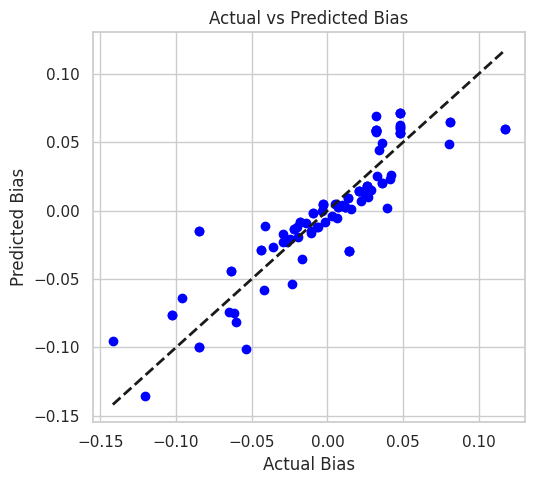

In [ ]:
import matplotlib.pyplot as plt

# Plot actual versus predicted values for Bias
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test['Bias'], y_pred[:, 0], color='blue')
plt.plot([y_test['Bias'].min(), y_test['Bias'].max()], [y_test['Bias'].min(), y_test['Bias'].max()], 'k--', lw=2)
plt.xlabel('Actual Bias')
plt.ylabel('Predicted Bias')
plt.title('Actual vs Predicted Bias')


plt.tight_layout()
plt.show()


# Splitting dataset into make and female datasets

<ipython-input-11-891b1f5ff1d3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_male.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-11-891b1f5ff1d3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_male.fillna(0, inplace=True)


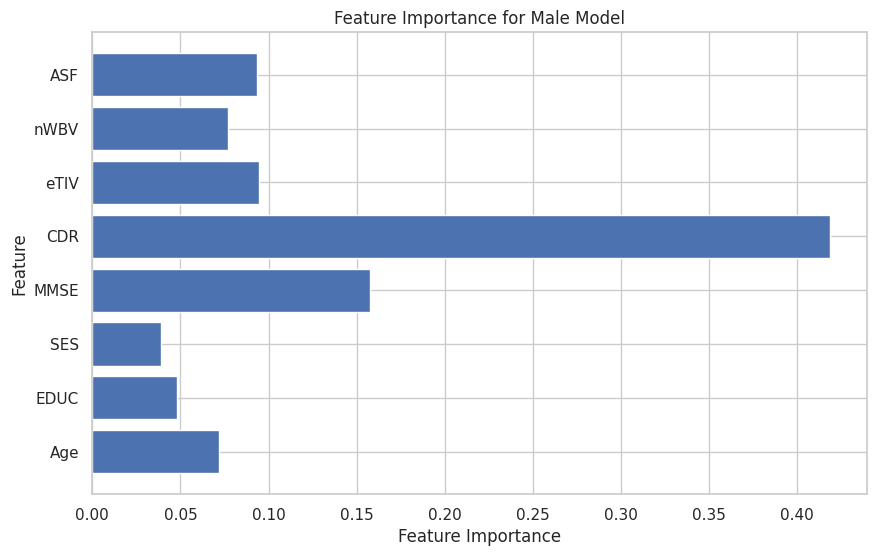

<ipython-input-11-891b1f5ff1d3>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_female.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-11-891b1f5ff1d3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_female.fillna(0, inplace=True)


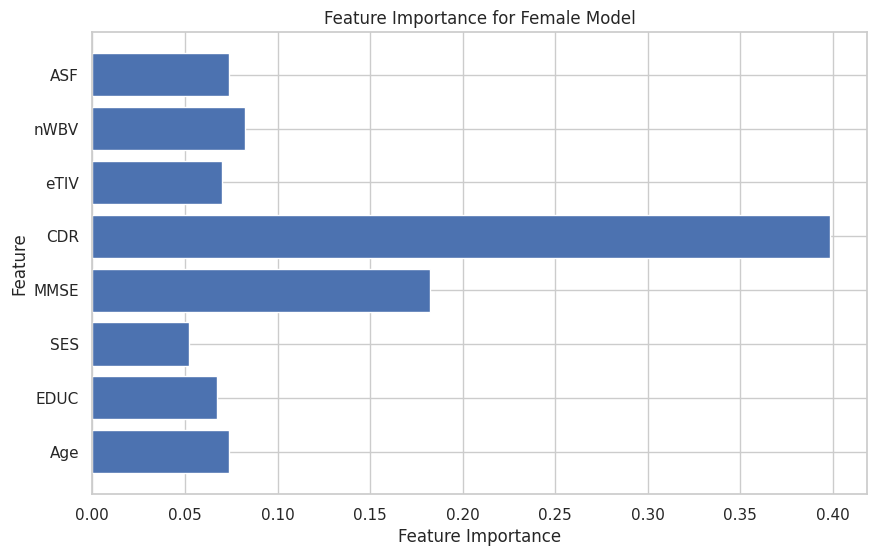

In [ ]:
from sklearn.ensemble import RandomForestClassifier




concatenated_df = pd.read_csv("/content/alzheimer.csv")
# Separate male and female samples
male_subset = concatenated_df[concatenated_df['M/F'] == 'M']
female_subset = concatenated_df[concatenated_df['M/F'] == 'F']

# Features and target for male subset
X_male = male_subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]
y_male = male_subset['Group']

# Features and target for female subset
X_female = female_subset[['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]
y_female = female_subset['Group']


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

# Replace infinite values with NaN for male subset
X_male.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with 0 for male subset
X_male.fillna(0, inplace=True)

# Apply robust scaling for male subset
scaler = RobustScaler()
X_scaled_male = scaler.fit_transform(X_male)

# Train models for male subset
male_model = RandomForestClassifier()  # You can use any other classifier as needed
male_model.fit(X_scaled_male, y_male)

# Get feature importances for male model
male_feature_importances = male_model.feature_importances_

# Plot feature importances for male model
plt.figure(figsize=(10, 6))
plt.barh(X_male.columns, male_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Male Model')
plt.show()

# Replace infinite values with NaN for female subset
X_female.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with 0 for female subset
X_female.fillna(0, inplace=True)

# Apply robust scaling for female subset
scaler = RobustScaler()
X_scaled_female = scaler.fit_transform(X_female)

# Train models for female subset
female_model = RandomForestClassifier()  # You can use any other classifier as needed
female_model.fit(X_scaled_female, y_female)

# Get feature importances for female model
female_feature_importances = female_model.feature_importances_

# Plot feature importances for female model
plt.figure(figsize=(10, 6))
plt.barh(X_female.columns, female_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Female Model')
plt.show()


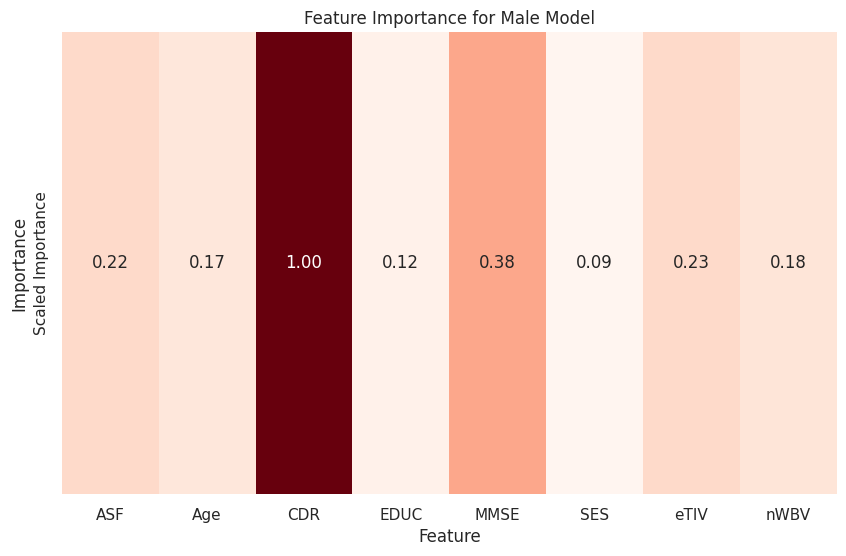

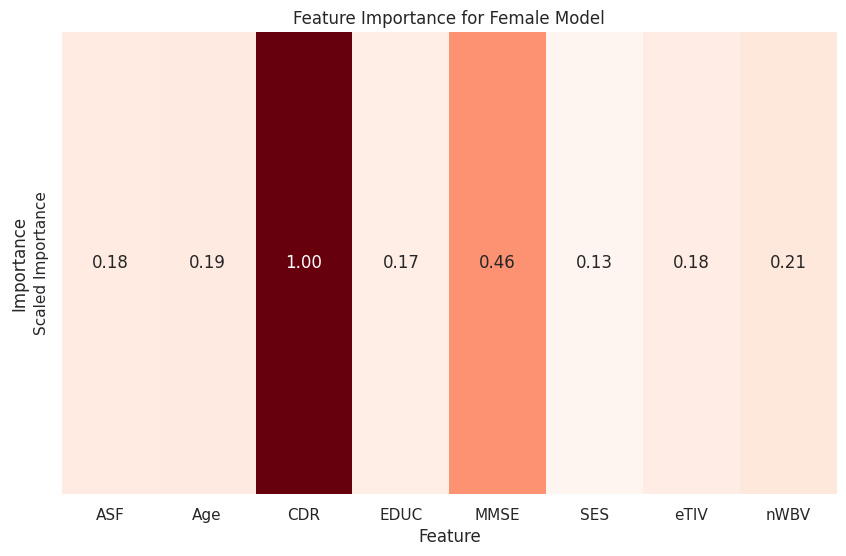

In [ ]:
import seaborn as sns

# Define a function to create a color-coded table
def visualize_feature_importance(feature_importances, feature_names, title):
    # Create a DataFrame from feature importances
    df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    df = df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # Scale importance values to range [0, 1] for color intensity
    df['Scaled Importance'] = df['Importance'] / df['Importance'].max()

    # Reshape DataFrame for visualization
    heatmap_data = df.pivot_table(index='Feature', values='Scaled Importance').transpose()

    # Plot the color-coded table
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt=".2f", cbar=False)
    plt.title(title)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

# Visualize feature importances for male model
visualize_feature_importance(male_feature_importances, X_male.columns, 'Feature Importance for Male Model')

# Visualize feature importances for female model
visualize_feature_importance(female_feature_importances, X_female.columns, 'Feature Importance for Female Model')
